In [24]:
import os
import sys
sys.path.append('/mnt/mnt/5TB_slot2/Tobias')
sys.path.append('/mnt/mnt/5TB_slot2/Tobias/TobiasPy/fastMRI')
sys.path.append('/mnt/mnt/4TB_pcie/fastBrain/')
import h5py
import numpy as np
import numpy.fft as nf
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from models.unet.unet_model import UnetModel as UnetModel
from FF_net import FF_net
from FF_net import FF_simple_net
from FF_net import FF_net_tanh
from FF_net import Complex_net
import argparse
from common.args import Args
import models.unet.run_unet  as Run
import torch.nn as nn
import logging
import pathlib
from pathlib import Path
import random
from torch.utils.data import Dataset
import time
from torch.nn import functional as F
import shutil
from tensorboardX import SummaryWriter
import torchvision
from torchvision import transforms, utils
import net_utils as nu
import calendar
import datetime
from longOne import ComplexFourier,ComplexEndToEnd
from complex_unet_model import ComplexUnetModel
from complex_end_to_end import ComplexEndToEnd, td_fourier_net, td_fourier_net_real

import sigpy as sp
import sigpy.plot as pl
from skimage.metrics import structural_similarity as np_ssim
import vd_spiral

from FF_net import Complex_net_ext

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sys.argv=['']
def create_arg_parser():
    timestamp = calendar.timegm(time.gmtime())
    human_readable = datetime.datetime.fromtimestamp(timestamp).isoformat()
    #human_readable="pure_inverse_fourier"
    human_readable="ComplexEndToEnd_Kspace_FourierTransform_Compare-Complex"
    parser = argparse.ArgumentParser(description="ML parameters")
    parser.add_argument('--num-pools', type=int, default=4, help='Number of U-Net pooling layers')
    parser.add_argument('--drop-prob', type=float, default=0.0, help='Dropout probability')
    parser.add_argument('--num-chans', type=int, default=32, help='Number of U-Net channels')

    parser.add_argument('--batch-size', default=32, type=int, help='Mini batch size')
    parser.add_argument('--num-epochs', type=int, default=250, help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=0.0001, help='Learning rate')
    parser.add_argument('--lr-step-size', type=int, default=100,
                        help='Period of learning rate decay')
    parser.add_argument('--lr-gamma', type=float, default=0.1,
                        help='Multiplicative factor of learning rate decay')
    parser.add_argument('--weight-decay', type=float, default=0.01,
                        help='Strength of weight decay regularization')
    parser.add_argument('--momentum', type=float, default=0.1,
                        help='Strength of optimizer momentum')

    parser.add_argument('--report-interval', type=int, default=10000, help='Period of loss reporting')
    parser.add_argument('--data-parallel', default=True,
                        help='If set, use multiple GPUs using data parallelism')
    parser.add_argument('--device', type=str, default='cuda',
                        help='Which device to train on. Set to "cuda" to use the GPU')
    parser.add_argument('--exp-dir', type=pathlib.Path, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_'+str(human_readable),
                        help='Path where model and results should be saved')
    parser.add_argument('--resume', action='store_true', default=False,
                        help='If set, resume the training from a previous model checkpoint. '
                             '"--checkpoint" should be set with this')
    parser.add_argument('--checkpoint', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_'+str(human_readable)+'/best_model.pt',
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--logdir', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/log/ff_lrelu_'+str(human_readable),
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--seed', default=42, type=int, help='Seed for random number generators')
    parser.add_argument('--resolution', default=128, type=int, help='Resolution of images')
    parser.add_argument('--device_ids', default=[2,3] , help='GPUS used')
    return parser
args=create_arg_parser().parse_args()
print("save to",args.checkpoint)

save to /mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_ComplexEndToEnd_Kspace_FourierTransform_Compare-Complex/best_model.pt


In [3]:
def test_fourier():
    sig = np.random.randn(args.resolution) + 1j*np.random.randn(320)
    F = np.fft.ifft(sig, axis=-1)
    # First half of inputs/outputs is real part, second half is imaginary part
    X = torch.from_numpy(np.hstack([sig.real, sig.imag])).double()
    Y = torch.from_numpy((F.real**2+F.imag**2)**(1/2)).double()
    return X,Y

class SliceData(Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """
    
    def __init__(self, root="/mnt/mnt/5TB_slot2/fastMRI/multicoil_train", sample_rate=1.):
        self.examples = []
        #potential to apply pre-process transform
        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            #random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]
        for fname in sorted(files):
            print(fname)
            try:
                #print(h5py.File(fname, 'r').keys())
                #maybe also only randomly select parts of slices. Otherwise lot of outer noise-like structures.
                xml = h5py.File(fname, 'r')['ismrmrd_header']
                kspace = h5py.File(fname, 'r')['kspace']
                num_slices = kspace.shape[0]
                num_channels=kspace.shape[1]
                if (kspace.shape[-2]<args.resolution) or (kspace.shape[-1]<args.resolution):# or num_channels!=16:
                    continue
                print(len(self.examples))
                for slice in range(num_slices):
                    crop_size = (min(args.resolution, kspace.shape[-2]),min(args.resolution, kspace.shape[-1]))
                    k=nu.center_crop(kspace[slice], crop_size)[0]
                    target=abs(nu.make_ift(k))
                    m=np.max(target)
                    if m>0:
                        target/=m
                    else:
                        continue
                    k=nu.to_tensor(k).unsqueeze(0)
                    #us=nu.apply_mask(k,r=3)[0]#*args.resolution no undersampling for now
                    us=k
                    us/=m
                    if np.isnan(np.sum(target)):
                        continue
                    X=us#.flatten()
                    print(X.shape)
                    #print(X.shape)
                    Y=nu.to_tensor(target)
                    #print(Y.shape)
                    #X,Y=test_fourier()
                    self.examples += [(fname, slice, X, Y)]
            except:
                print("Couldn't open file")
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, i):
        fname, slice, f, t = self.examples[i]
#         with h5py.File(fname, 'r') as data:
#             full=to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, full.shape[-3]),min(args.resolution, full.shape[-2]))          
#             full=complex_center_crop(full,crop_size)
            
#             kspace = to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, kspace.shape[-3]), min(args.resolution, kspace.shape[-2]))
#             kspace=apply_mask(kspace)[0]
#             kspace = complex_center_crop(kspace, crop_size)
            
        return (f, t)

In [4]:
def create_data_loaders():
    #batch_size=32
    #mask_func = None
    #if args.mask_kspace:
    #    mask_func = MaskFunc(args.center_fractions, args.accelerations)
    train_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_train",sample_rate=0.25)
    dev_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.25)
    test_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.05)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )
    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )
    test_loader=None
#     test_loader = DataLoader(
#         dataset=test_data,
#         num_workers=0,
#         pin_memory=True,
#     )
    return train_loader, dev_loader, test_loader

In [5]:
t=time.time()
train_loader, dev_loader, test_loader= create_data_loaders()
print("Time taken to load data: ",time.time()-t)

/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002442.h5
0
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002466.h5
16
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2]

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_201_6002917.h5
256
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_201_6002923.h5
272
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128,

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_201_6003009.h5
510
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_201_6003016.h5
526
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128,

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000576.h5
762
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000585.h5

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000311.h5
1002
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000319.h5
1018
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000450.h5
1242
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000453.h5
1258
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6001994.h5
1498
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_b

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090175.h5
1738
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090185.h5
1754
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090242.h5
1976
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090243.h5
1992
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090389.h5
2228
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090395.h5
2244
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXFLAIR_200_6002564.h5
14
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXFLAIR_200_6002625.h5
30
torch.Size([1, 128, 128, 2])
torch.Size([1, 1

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_202_6000293.h5
248
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_202_6000378.h5
264
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_208_2080407.h5
520
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_208_2080427.h5
536
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000357.h5
776
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_206_2060052.h5
788
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002495.h5
1026
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002514.h5
1042
torch.Size([1, 128, 128, 2])
torch.Size([1, 128

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_202_2020417.h5
1280
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_202_2020425.h5
1296
torch.Size([1, 128, 128, 2])
torch.Size([1, 128

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060032.h5
1520
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060069.h5
1536
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_208_2080123.h5
1776
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_208_2080177.h5
1792
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001021.h5
2014
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001065.h5
2030
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_202_6000378.h5
62
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_205_6000098.h5
78
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1,

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_207_2070240.h5
318
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 12

with torch.no_grad():
        for (f, t) in train_loader:
            print(f.shape,t.shape)
            plt.imshow(abs(nu.make_ift(nu.to_complex(f)))[0,0,:,:])
            plt.show()
            plt.imshow(t[0,:,:])
            plt.show()

In [6]:
def build_model(args,chans=args.num_chans,num_pool_layers=args.num_pools,drop_prob=0.05):
    #check every time which gpus are available!
    #device_ids=[2,3,1]
    torch.cuda.empty_cache()
    device_ids=args.device_ids
    model=td_fourier_net(in_chans=1,out_chans=1,drop_prob=args.drop_prob,resolution=args.resolution).to(f'{args.device}:{device_ids[0]}')
    model=model.double()
    if args.data_parallel and args.device=="cuda":
        model = nn.DataParallel(model,device_ids=device_ids)
    print("Model build successfully")
    #vis_weights(model)
    return model

def vis_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)
            # Heat map of neuron weights
            plt.imshow(param.data.cpu(), vmin=np.min(param.data.cpu().numpy()), vmax=np.max(param.data.cpu().numpy()), cmap='coolwarm')
            plt.show()
#            fig,ax=plt.subplots(320,1,figsize=(16,16))
#             for i in range(320):
#                 ax[i].plot(param.data.cpu()[i,:320])
#             plt.show()

def build_optim(args,params):
    optimizer = torch.optim.Adadelta(params)
    return optimizer

def load_model(checkpoint_file,args):
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    model = build_model(args)
    model.load_state_dict(checkpoint['model'])

    optimizer = build_optim(args, model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("Model load successfully")
    return checkpoint, model, optimizer

def save_model(args, exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best):
    torch.save(
        {
            'epoch': epoch,
            'args': args,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_dev_loss': best_dev_loss,
            'exp_dir': exp_dir
        },
        f=exp_dir / 'model.pt'
    )
    if is_new_best:
        shutil.copyfile(exp_dir / 'model.pt', exp_dir / 'best_model.pt')
        
def eval_loss(output,target):
    l1=F.l1_loss(output, target).item()
    #print(l1)
    mse=F.mse_loss(output, target).item()
    #print(mse)
    try:
        ssim=np_ssim(output.to("cpu").detach().numpy(), target.squeeze(1).to('cpu').detach().numpy())
    except:
        print(output.shape,target.shape)
        ssim=np_ssim(output[0].to("cpu").detach().numpy(), target[0].squeeze(1).to('cpu').detach().numpy())
    #print(ssim)
    return l1,mse,ssim
        
def visualize(args, epoch, model, data_loader, writer):
    def save_image(image, tag):
        image -= image.min()
        image /= image.max()
        grid = torchvision.utils.make_grid(image, nrow=4, pad_value=1)
        writer.add_image(tag, grid, epoch)
    model.eval()
    
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            input, target = data
            input = input.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            target = target.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            output = model(input)
            save_image(target[0,:,:], 'Target')
            save_image(output[0,:,:], 'Reconstruction')
            save_image(torch.abs(target - output)[0,:,:], 'Error')
            break

In [7]:
def train_epoch(args, epoch, model, data_loader, optimizer, writer):
    model.train()
    print(model.device_ids)
    avg_loss = 0.
    start_epoch = start_iter = time.perf_counter()
    global_step = epoch * len(data_loader)
    for iter, data in enumerate(data_loader):
        f, t = data
        input = f.to(f'{args.device}:{model.device_ids[0]}')
        target = t.to(f'{args.device}:{model.device_ids[0]}')
        output_r,output_i = model(input)
        output = (output_r.squeeze(1)**2+output_i.squeeze(1)**2)**(1/2)
        
        loss = F.mse_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()
        writer.add_scalar('TrainLoss', loss.item(), global_step + iter)

#         if iter % args.report_interval == 0:
#             print(f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] ',
#                 f'Iter = [{iter:4d}/{len(data_loader):4d}] ',
#                 f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} ',
#                 f'Time = {time.perf_counter() - start_iter:.4f}s')
#             logging.info(
#                 f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] '
#                 f'Iter = [{iter:4d}/{len(data_loader):4d}] '
#                 f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} '
#                 f'Time = {time.perf_counter() - start_iter:.4f}s',
#             )
        start_iter = time.perf_counter()
    return avg_loss, time.perf_counter() - start_epoch

def evaluate(args, epoch, model, data_loader, writer):
    model.eval()
    losses = []
    start = time.perf_counter()
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            f, t = data
            input = f.to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            output_r,output_i = model(input)
            output = (output_r.squeeze(1)**2+output_i.squeeze(1)**2)**(1/2)

            #mean = mean.unsqueeze(1).unsqueeze(2).to(args.device)
            #std = std.unsqueeze(1).unsqueeze(2).to(args.device)
            #target = target * std + mean
            #output = output * std + mean

            #norm = norm.unsqueeze(1).unsqueeze(2).to(args.device)
            #loss = F.mse_loss(output / norm, target / norm, size_average=False)
            loss = F.mse_loss(output, target)
            losses.append(loss.item())
        writer.add_scalar('Dev_Loss', np.mean(losses), epoch)
        print('Dev_Loss', np.mean(losses),'Epoch', epoch)
    return np.mean(losses), time.perf_counter() - start

Model build successfully
[2, 3]
Dev_Loss 0.005134942622981613 Epoch 0
Epoch = [   0/ 250] TrainLoss = 7.025  DevLoss = 0.005135 TrainTime = 20.0786s DevTime = 13.8094s


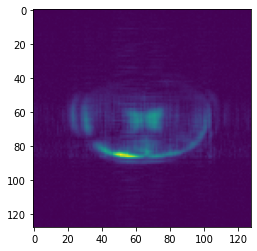

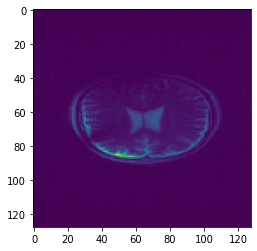

Time taken for epoch:  34.23898196220398
[2, 3]
Dev_Loss 0.0017784336902187516 Epoch 1
Epoch = [   1/ 250] TrainLoss = 0.003204  DevLoss = 0.001778 TrainTime = 17.6181s DevTime = 13.3399s


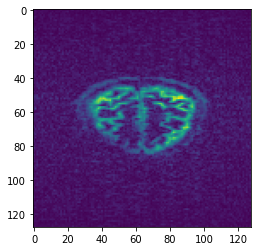

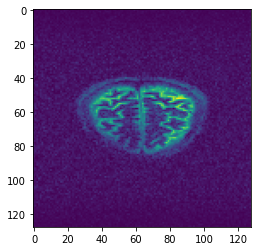

Time taken for epoch:  31.324491500854492
[2, 3]
Dev_Loss 0.0009284800595862377 Epoch 2
Epoch = [   2/ 250] TrainLoss = 0.002606  DevLoss = 0.0009285 TrainTime = 15.6356s DevTime = 13.8818s


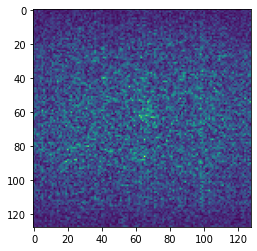

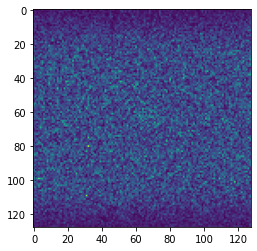

Time taken for epoch:  29.95392870903015
[2, 3]
Dev_Loss 0.0007336954346144429 Epoch 3
Epoch = [   3/ 250] TrainLoss = 0.002145  DevLoss = 0.0007337 TrainTime = 17.3698s DevTime = 13.6976s


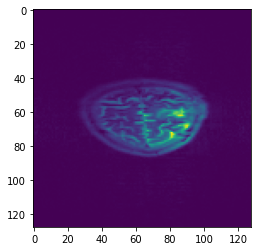

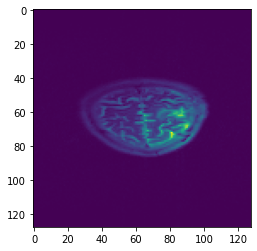

Time taken for epoch:  31.39904522895813
[2, 3]
Dev_Loss 0.0036127727578140283 Epoch 4
Epoch = [   4/ 250] TrainLoss = 0.001916  DevLoss = 0.003613 TrainTime = 17.3468s DevTime = 14.0892s


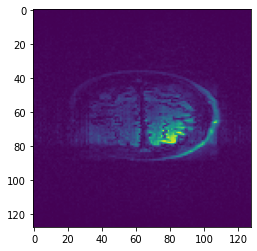

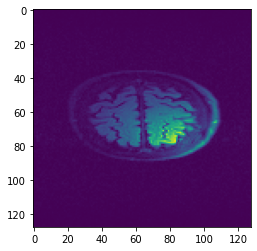

Time taken for epoch:  31.772592067718506
[2, 3]
Dev_Loss 0.000393402704960886 Epoch 5
Epoch = [   5/ 250] TrainLoss = 0.001837  DevLoss = 0.0003934 TrainTime = 16.0640s DevTime = 13.7805s


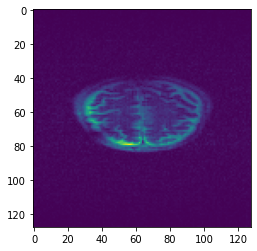

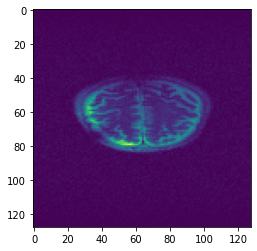

Time taken for epoch:  30.198763847351074
[2, 3]
Dev_Loss 0.00041923808774389955 Epoch 6
Epoch = [   6/ 250] TrainLoss = 0.001716  DevLoss = 0.0004192 TrainTime = 16.1207s DevTime = 13.9109s


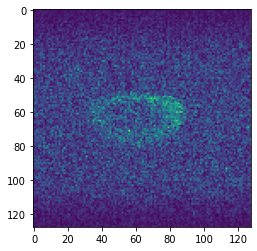

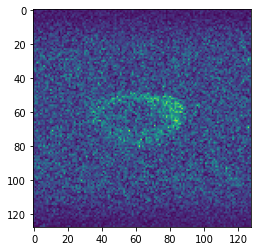

Time taken for epoch:  30.393598556518555
[2, 3]
Dev_Loss 0.0014181148580172571 Epoch 7
Epoch = [   7/ 250] TrainLoss = 0.001641  DevLoss = 0.001418 TrainTime = 16.7842s DevTime = 13.5938s


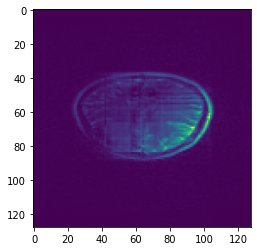

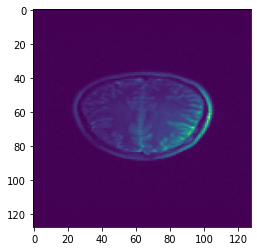

Time taken for epoch:  30.714893579483032
[2, 3]
Dev_Loss 0.00041918169626456426 Epoch 8
Epoch = [   8/ 250] TrainLoss = 0.001322  DevLoss = 0.0004192 TrainTime = 15.4322s DevTime = 13.6817s


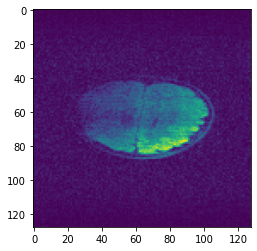

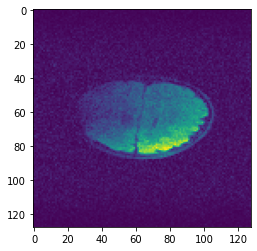

Time taken for epoch:  29.470296144485474
[2, 3]
Dev_Loss 0.0010930136859562492 Epoch 9
Epoch = [   9/ 250] TrainLoss = 0.001048  DevLoss = 0.001093 TrainTime = 16.5640s DevTime = 13.3434s


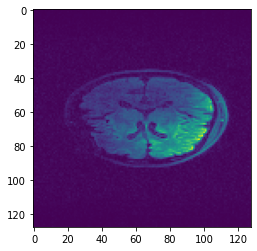

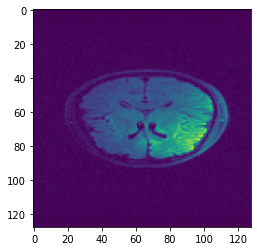

Time taken for epoch:  30.249602556228638
[2, 3]
Dev_Loss 0.0033430121815548794 Epoch 10
Epoch = [  10/ 250] TrainLoss = 0.001187  DevLoss = 0.003343 TrainTime = 15.3161s DevTime = 13.5042s


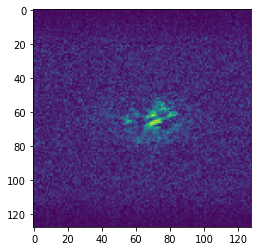

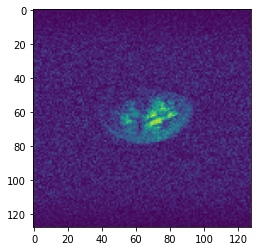

Time taken for epoch:  29.17685842514038
[2, 3]
Dev_Loss 0.006185391911055198 Epoch 11
Epoch = [  11/ 250] TrainLoss = 0.001316  DevLoss = 0.006185 TrainTime = 15.2751s DevTime = 13.6856s


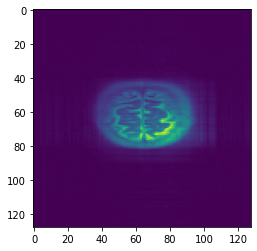

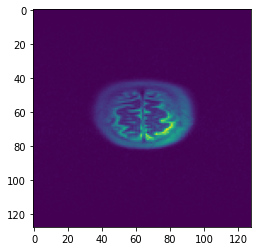

Time taken for epoch:  29.27195954322815
[2, 3]
Dev_Loss 0.001428460208018896 Epoch 12
Epoch = [  12/ 250] TrainLoss = 0.001126  DevLoss = 0.001428 TrainTime = 15.7574s DevTime = 13.7296s


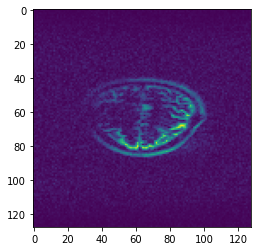

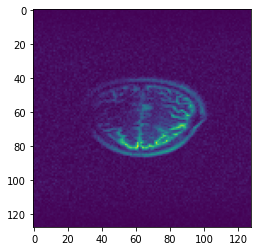

Time taken for epoch:  29.843066930770874
[2, 3]
Dev_Loss 0.001986065772949064 Epoch 13
Epoch = [  13/ 250] TrainLoss = 0.0009259  DevLoss = 0.001986 TrainTime = 16.6215s DevTime = 13.4530s


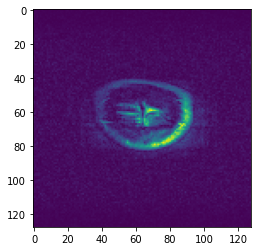

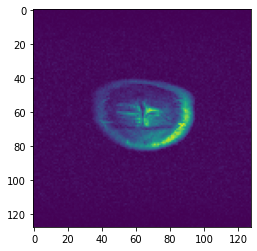

Time taken for epoch:  30.433884143829346
[2, 3]
Dev_Loss 0.00045276398976579625 Epoch 14
Epoch = [  14/ 250] TrainLoss = 0.00091  DevLoss = 0.0004528 TrainTime = 15.4459s DevTime = 13.5666s


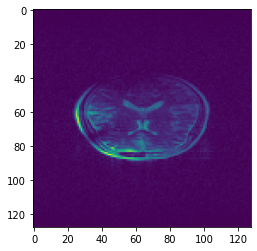

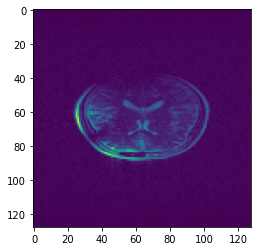

Time taken for epoch:  29.350187063217163
[2, 3]
Dev_Loss 0.0005819195733852437 Epoch 15
Epoch = [  15/ 250] TrainLoss = 0.0008874  DevLoss = 0.0005819 TrainTime = 16.0930s DevTime = 14.2925s


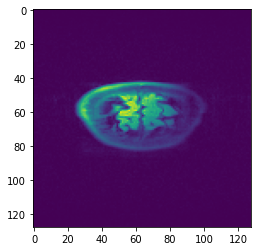

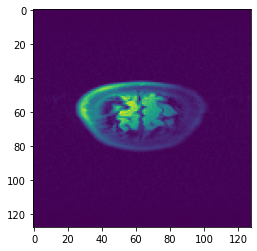

Time taken for epoch:  30.705793380737305
[2, 3]
Dev_Loss 0.0005363492324038816 Epoch 16
Epoch = [  16/ 250] TrainLoss = 0.0008232  DevLoss = 0.0005363 TrainTime = 16.1484s DevTime = 14.6484s


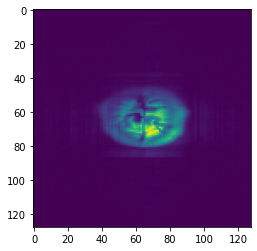

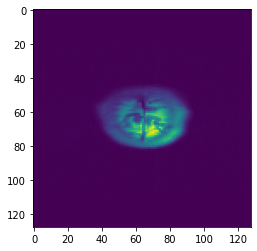

Time taken for epoch:  31.120763301849365
[2, 3]
Dev_Loss 4.985066179996878e-05 Epoch 17
Epoch = [  17/ 250] TrainLoss = 0.0007541  DevLoss = 4.985e-05 TrainTime = 16.8742s DevTime = 13.2870s


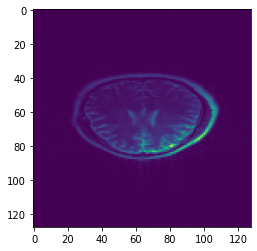

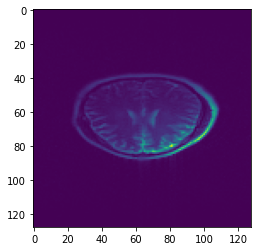

Time taken for epoch:  30.51253342628479
[2, 3]
Dev_Loss 0.00015555863485045788 Epoch 18
Epoch = [  18/ 250] TrainLoss = 0.000638  DevLoss = 0.0001556 TrainTime = 18.4333s DevTime = 14.0020s


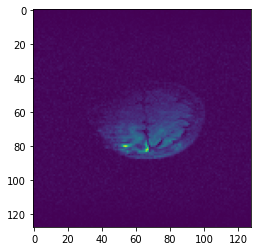

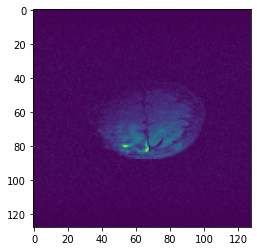

Time taken for epoch:  32.78975701332092
[2, 3]
Dev_Loss 0.0013093247356405226 Epoch 19
Epoch = [  19/ 250] TrainLoss = 0.0006671  DevLoss = 0.001309 TrainTime = 15.6609s DevTime = 13.7557s


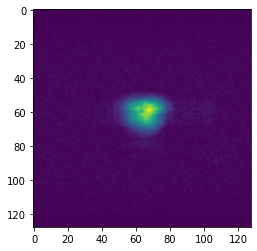

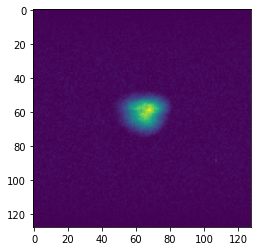

Time taken for epoch:  29.783341884613037
[2, 3]
Dev_Loss 0.00020164032042487378 Epoch 20
Epoch = [  20/ 250] TrainLoss = 0.001041  DevLoss = 0.0002016 TrainTime = 17.3214s DevTime = 13.6583s


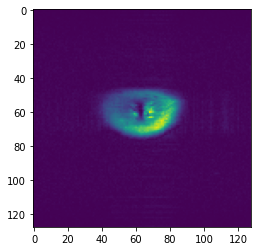

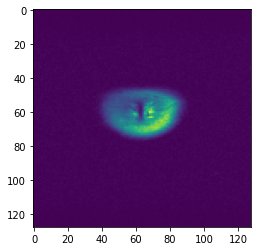

Time taken for epoch:  31.326903820037842
[2, 3]
Dev_Loss 0.0004763202717776381 Epoch 21
Epoch = [  21/ 250] TrainLoss = 0.0006827  DevLoss = 0.0004763 TrainTime = 16.2484s DevTime = 13.3219s


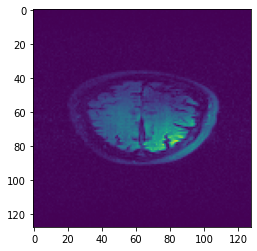

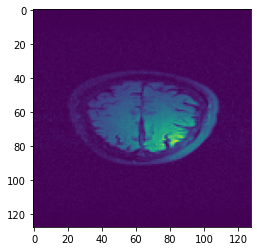

Time taken for epoch:  30.031543254852295
[2, 3]
Dev_Loss 0.0010871444893355436 Epoch 22
Epoch = [  22/ 250] TrainLoss = 0.00071  DevLoss = 0.001087 TrainTime = 15.1169s DevTime = 13.4977s


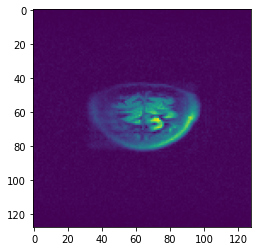

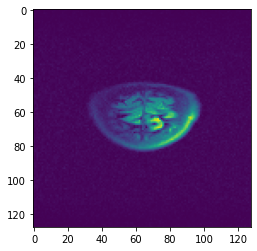

Time taken for epoch:  28.945167064666748
[2, 3]
Dev_Loss 0.007956327865836388 Epoch 23
Epoch = [  23/ 250] TrainLoss = 0.0006969  DevLoss = 0.007956 TrainTime = 15.2195s DevTime = 13.7499s


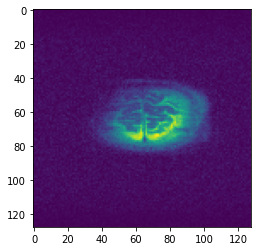

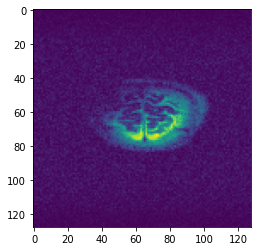

Time taken for epoch:  29.313491821289062
[2, 3]
Dev_Loss 3.2990960126001945e-05 Epoch 24
Epoch = [  24/ 250] TrainLoss = 0.001098  DevLoss = 3.299e-05 TrainTime = 16.1678s DevTime = 13.4593s


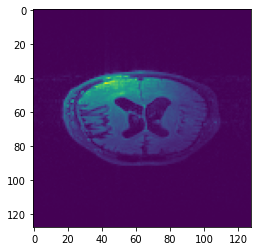

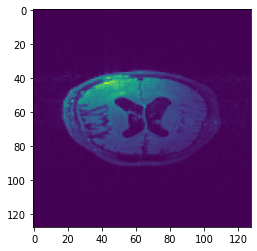

Time taken for epoch:  29.949745893478394
[2, 3]
Dev_Loss 0.0004023360857970936 Epoch 25
Epoch = [  25/ 250] TrainLoss = 0.0006675  DevLoss = 0.0004023 TrainTime = 16.2459s DevTime = 13.5737s


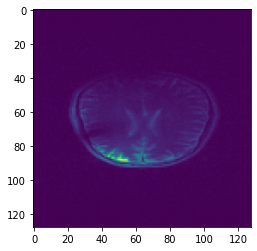

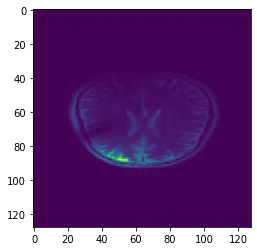

Time taken for epoch:  30.142860889434814
[2, 3]
Dev_Loss 0.00014774587321083056 Epoch 26
Epoch = [  26/ 250] TrainLoss = 0.0006008  DevLoss = 0.0001477 TrainTime = 15.6927s DevTime = 13.6347s


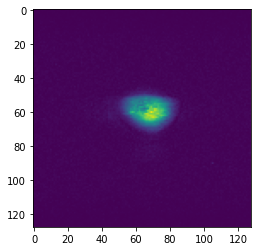

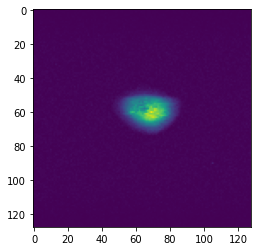

Time taken for epoch:  29.66864848136902
[2, 3]
Dev_Loss 8.94985406614234e-05 Epoch 27
Epoch = [  27/ 250] TrainLoss = 0.0006409  DevLoss = 8.95e-05 TrainTime = 15.4720s DevTime = 13.3057s


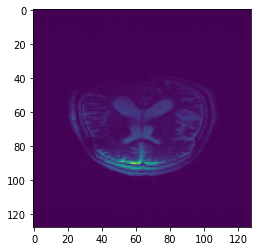

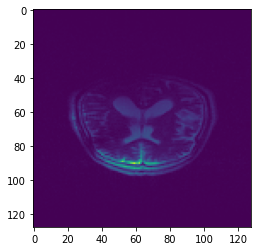

Time taken for epoch:  29.11701512336731
[2, 3]
Dev_Loss 0.005782969322135758 Epoch 28
Epoch = [  28/ 250] TrainLoss = 0.0006743  DevLoss = 0.005783 TrainTime = 15.7270s DevTime = 13.3368s


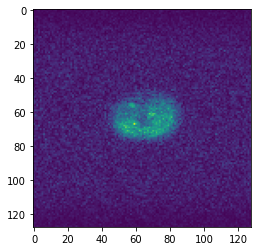

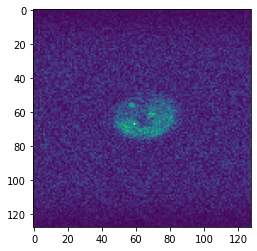

Time taken for epoch:  29.42760944366455
[2, 3]
Dev_Loss 0.0003163409346782766 Epoch 29
Epoch = [  29/ 250] TrainLoss = 0.000932  DevLoss = 0.0003163 TrainTime = 15.0793s DevTime = 13.3547s


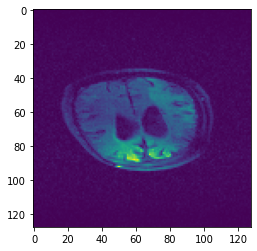

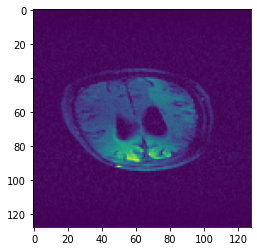

Time taken for epoch:  28.785128355026245
[2, 3]
Dev_Loss 0.0006915193879182329 Epoch 30
Epoch = [  30/ 250] TrainLoss = 0.000835  DevLoss = 0.0006915 TrainTime = 15.5061s DevTime = 13.2815s


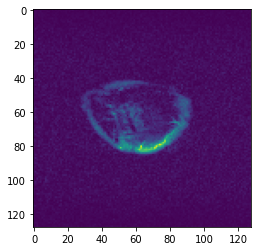

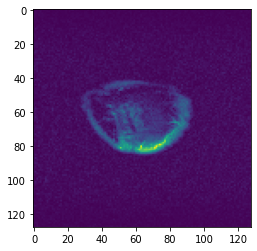

Time taken for epoch:  29.129103660583496
[2, 3]
Dev_Loss 0.00011034441984888356 Epoch 31
Epoch = [  31/ 250] TrainLoss = 0.0006676  DevLoss = 0.0001103 TrainTime = 15.5723s DevTime = 13.5885s


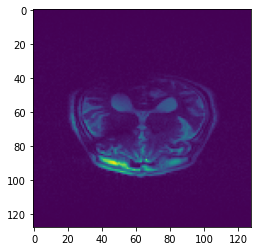

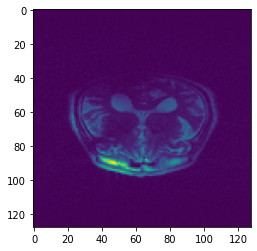

Time taken for epoch:  29.501341819763184
[2, 3]


In [ ]:
def train(args): 
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(logdir=str(args.logdir)) #log directory for run

    if args.resume: #be aware of the option
        checkpoint, model, optimizer = load_model(args.checkpoint,args)
        args = checkpoint['args']
        best_dev_loss = checkpoint['best_dev_loss']
        #start_epoch = checkpoint['epoch']
        start_epoch = 0
        del checkpoint
    else:
        model = build_model(args)
        optimizer = build_optim(args, model.parameters())
        best_dev_loss = 1e9
        start_epoch = 0
    logging.info(args)
    logging.info(model)

    #train_loader,dev_loader,test_loader = create_data_loaders()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_step_size, args.lr_gamma)
    optimizer.step()

    for epoch in range(start_epoch, args.num_epochs):
        ti=time.time()
        scheduler.step(epoch)
        train_loss, train_time = train_epoch(args, epoch, model, train_loader, optimizer, writer)
        dev_loss, dev_time = evaluate(args, epoch, model, dev_loader, writer)
        #visualize(args, epoch, model, train_loader, writer)

        is_new_best = dev_loss < best_dev_loss
        best_dev_loss = min(best_dev_loss, dev_loss)
        save_model(args, args.exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best)
        print(f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} ',
        f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s')
        
        for iter, data in enumerate(train_loader):
            kspace, full = data
            input = kspace.to(f'{args.device}:{model.device_ids[0]}')
            target = full.to(f'{args.device}:{model.device_ids[0]}')
            output_r,output_i = model(input)
            output_r=output_r.to('cpu').detach().numpy()
            output_i=output_i.to('cpu').detach().numpy()
            output = output_r+output_i*1j
            image = abs(output.squeeze(1))
            #print(output)
            plt.imshow(image[0,:,:])
            plt.show()
            plt.imshow(target[0,:,:].to('cpu').detach().numpy())
            plt.show()
            break;
        
        logging.info(
            f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} '
            f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s',
        )
        print("Time taken for epoch: ",time.time()-ti)
    writer.close()
    return dev_loss
    
train(args)

In [8]:
def train(args): 
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(logdir=str(args.logdir)) #log directory for run

    if args.resume: #be aware of the option
        checkpoint, model, optimizer = load_model(args.checkpoint,args)
        args = checkpoint['args']
        best_dev_loss = checkpoint['best_dev_loss']
        #start_epoch = checkpoint['epoch']
        start_epoch = 0
        del checkpoint
    else:
        model = build_model(args)
        optimizer = build_optim(args, model.parameters())
        best_dev_loss = 1e9
        start_epoch = 0
    logging.info(args)
    logging.info(model)

    #train_loader,dev_loader,test_loader = create_data_loaders()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_step_size, args.lr_gamma)
    optimizer.step()

    for epoch in range(start_epoch, args.num_epochs):
        ti=time.time()
        scheduler.step(epoch)
        train_loss, train_time = train_epoch(args, epoch, model, train_loader, optimizer, writer)
        dev_loss, dev_time = evaluate(args, epoch, model, dev_loader, writer)
        #visualize(args, epoch, model, train_loader, writer)

        is_new_best = dev_loss < best_dev_loss
        best_dev_loss = min(best_dev_loss, dev_loss)
        save_model(args, args.exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best)
        print(f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} ',
        f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s')
        
        for iter, data in enumerate(train_loader):
            kspace, full = data
            input = kspace.to(f'{args.device}:{model.device_ids[0]}')
            target = full.to(f'{args.device}:{model.device_ids[0]}')
            output_r,output_i = model(input)
            output_r=output_r.to('cpu').detach().numpy()
            output_i=output_i.to('cpu').detach().numpy()
            output = output_r+output_i*1j
            image = abs(output.squeeze(1))
            #print(output)
            plt.imshow(image[0,:,:])
            plt.show()
            plt.imshow(target[0,:,:].to('cpu').detach().numpy())
            plt.show()
            break;
        
        logging.info(
            f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} '
            f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s',
        )
        print("Time taken for epoch: ",time.time()-ti)
    writer.close()
    return dev_loss

In [25]:
#compare, contrast

human_readable="ComplexEndToEnd_Kspace_FourierTransform_Compare-Real3"
#args.device_ids=[0,1]
args.exp_dir=Path('/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_'+str(human_readable))
args.checkpoint='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_'+str(human_readable)+'/best_model.pt'
args.logdir='/mnt/mnt/5TB_slot2/Tobias/Thesis/log/ff_lrelu_'+str(human_readable)
def build_model(args,chans=args.num_chans,num_pool_layers=args.num_pools,drop_prob=0.05):
    #check every time which gpus are available!
    #device_ids=[2,3,1]
    torch.cuda.empty_cache()
    device_ids=args.device_ids
    model=td_fourier_net_real(in_chans=1,out_chans=1,drop_prob=args.drop_prob,resolution=args.resolution).to(f'{args.device}:{device_ids[0]}')
    model=model.double()
    if args.data_parallel and args.device=="cuda":
        model = nn.DataParallel(model,device_ids=device_ids)
    print("Model build successfully")
    #vis_weights(model)
    return model

train(args)

Model build successfully
[2, 3]
torch.Size([16, 1, 256, 1, 128])
torch.Size([16, 1, 256, 1, 128])


RuntimeError: The size of tensor a (128) must match the size of tensor b (0) at non-singleton dimension 3

In [11]:
#f ="/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelue_2020/best_model.pt"
checkpoint, model, optimizer = load_model(args.checkpoint,args)
model.eval()

Model build successfully
Model load successfully


DataParallel(
  (module): td_fourier_net_real(
    (c_layer1): Conv2d(1, 256, kernel_size=(1, 256), stride=(1, 1), bias=False)
    (c_layer2): Conv2d(1, 256, kernel_size=(1, 128), stride=(1, 1), bias=False)
  )
)

module.c_layer1.weight tensor([[[[-2.9060e-03, -9.8300e-05, -2.3687e-03,  ..., -2.8377e-03,
            5.0618e-03, -1.3558e-03]]],


        [[[-1.3918e-03, -4.9763e-03, -4.5746e-03,  ...,  1.4024e-03,
           -7.1104e-04, -4.6172e-03]]],


        [[[ 4.8820e-03,  7.0898e-04, -9.7798e-04,  ...,  2.3811e-04,
           -9.2410e-03, -1.5732e-03]]],


        ...,


        [[[-1.2218e-03,  7.2836e-03,  1.9655e-03,  ...,  3.5227e-03,
            4.9202e-03, -9.4596e-05]]],


        [[[ 1.0517e-03,  2.4990e-03,  2.3662e-03,  ..., -2.0693e-03,
            2.2731e-03, -2.9346e-03]]],


        [[[ 6.6774e-03, -1.1871e-03, -5.6755e-04,  ...,  2.4228e-03,
           -2.8749e-03,  5.2736e-04]]]], device='cuda:2', dtype=torch.float64)


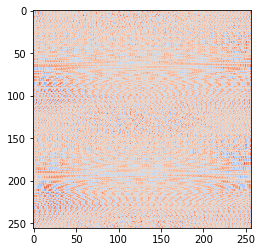

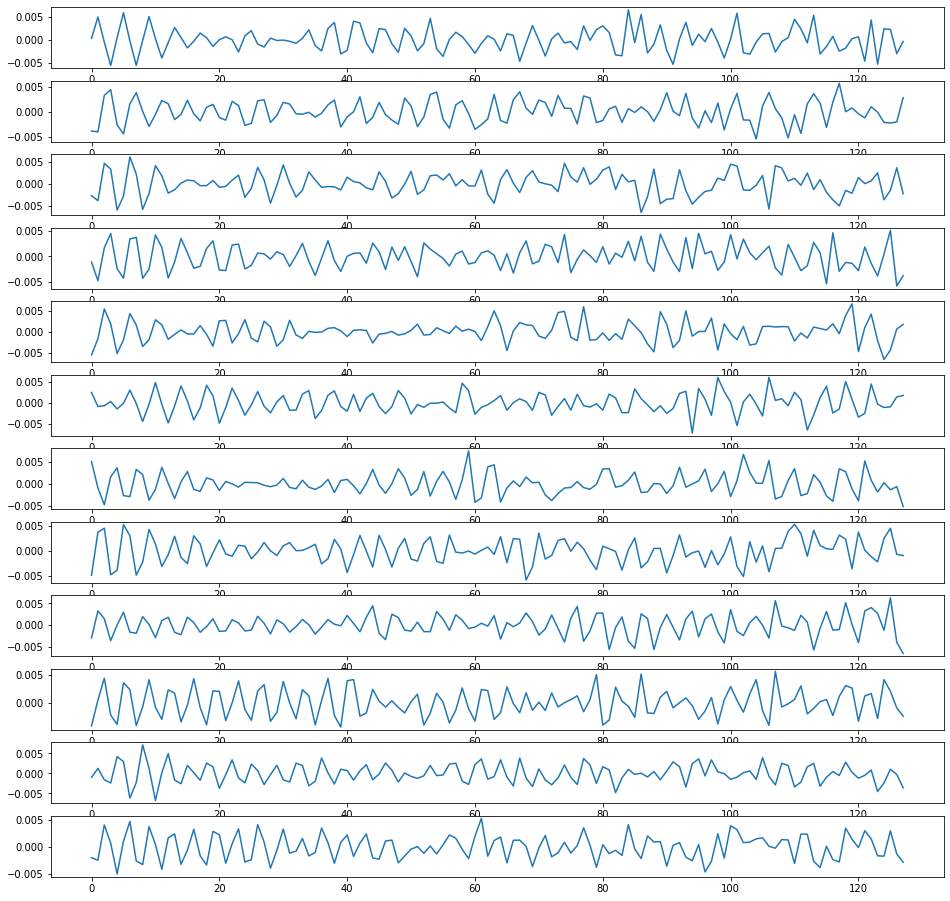

module.c_layer2.weight tensor([[[[-3.4031e-03,  5.0226e-03, -2.4895e-03,  ...,  2.6833e-03,
           -4.5981e-05, -2.7727e-03]]],


        [[[-1.6822e-03,  4.5828e-03, -2.2880e-03,  ...,  4.9943e-03,
           -2.5050e-03,  2.0791e-03]]],


        [[[ 3.2648e-03, -4.3233e-03,  2.3620e-03,  ...,  5.8821e-03,
           -4.9244e-04,  1.0696e-03]]],


        ...,


        [[[-8.2364e-03,  7.9570e-03, -3.6046e-03,  ...,  2.4999e-03,
           -3.9156e-03,  3.7125e-03]]],


        [[[-1.2051e-03,  5.8015e-03, -7.1402e-03,  ...,  1.1385e-02,
           -1.0597e-02,  8.7689e-03]]],


        [[[-6.4860e-03,  9.6853e-03, -1.1559e-02,  ..., -1.1751e-02,
            1.0581e-02, -6.4424e-03]]]], device='cuda:2', dtype=torch.float64)


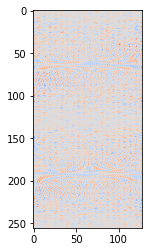

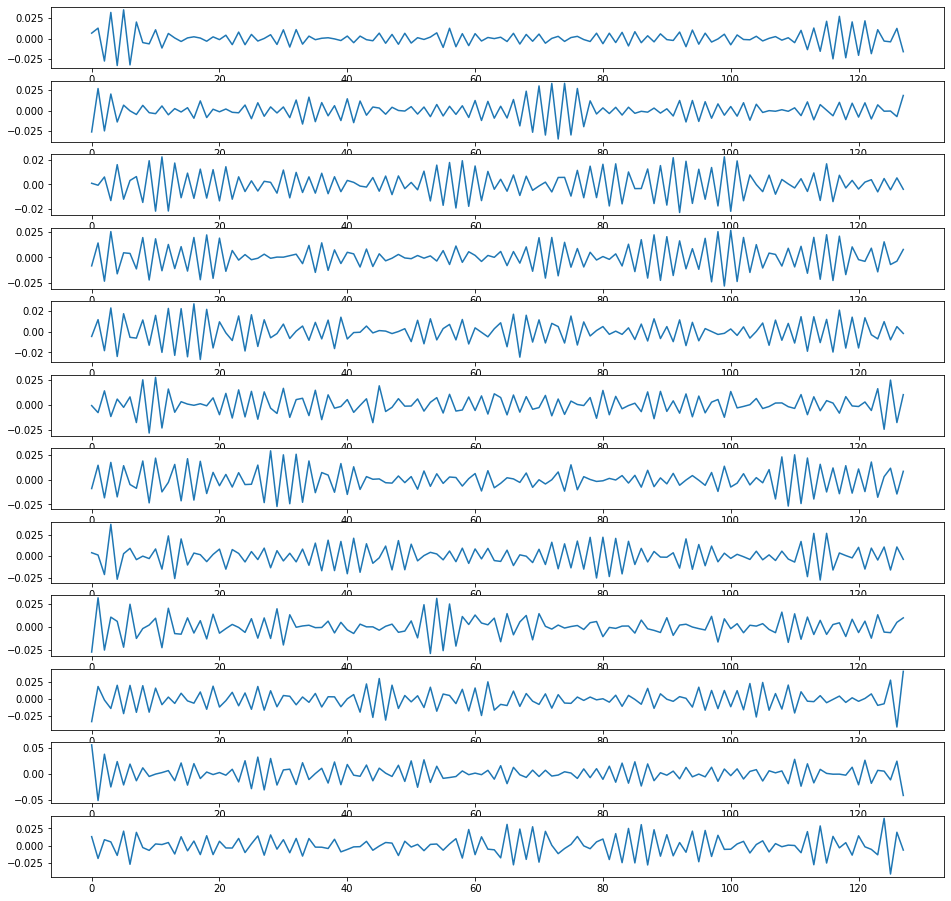

In [12]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        #plt.imshow(nf.ifftshift(param.data.cpu()[:,0,0,:]), vmin=-1, vmax=1, cmap='coolwarm')
        # Heat map of neuron weights
        weights=nf.ifftshift(param.data.cpu()[:,0,0,:])
        np.save(name+'.npy', param.data.cpu())
        plt.imshow(weights, vmin=np.min(param.data.cpu().numpy()), vmax=np.max(param.data.cpu().numpy()), cmap='coolwarm')
        plt.show()
        fig,ax=plt.subplots(args.resolution//10,1,figsize=(16,16))
        for i in range(args.resolution//10):
            ax[i].plot(weights[i,:args.resolution])
        plt.show()

In [ ]:
def train_plain(args): 
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(logdir=str(args.logdir)) #log directory for run
    if args.resume: #be aware of the option
        checkpoint, model, optimizer = load_model(args.checkpoint,args)
        args = checkpoint['args']
        best_dev_loss = checkpoint['best_dev_loss']
        #start_epoch = checkpoint['epoch']
        start_epoch = 0
        del checkpoint
    else:
        model = build_model(args)
        optimizer = build_optim(args, model.parameters())
        best_dev_loss = 1e9
        start_epoch = 0
    #train_loader,dev_loader,test_loader = create_data_loaders()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_step_size, args.lr_gamma)
    optimizer.step()

    for epoch in range(start_epoch, args.num_epochs):
        ti=time.time()
        scheduler.step(epoch)
        train_loss, train_time = train_epoch(args, epoch, model, train_loader, optimizer, writer)
        dev_loss, dev_time = evaluate(args, epoch, model, dev_loader, writer)
        #visualize(args, epoch, model, train_loader, writer)

#         is_new_best = dev_loss < best_dev_loss
#         best_dev_loss = min(best_dev_loss, dev_loss)
#         save_model(args, args.exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best)
    writer.close()
    return dev_loss

def run_model(lr):
    print(lr)
    args.lr=lr
    return train_plain(args)

In [ ]:
from hyperopt import hp, tpe, fmin

# Single line bayesian optimization of polynomial function
args.num_epochs=100
best = fmin(fn=lambda x: run_model(x),
            space=hp.normal('x', 0.0001, 0.5),
            algo=tpe.suggest,
            max_evals=100)

In [ ]:
print(best)

In [30]:
c=args.checkpoint#"/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_pure_inverse_fourier/best_model.pt
print(c)
#c='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_ComplexEndToEnd'+'/model.pt'
checkpoint, model, optimizer = load_model(c,args)
model.eval()
losses=[]
for iter, data in enumerate(train_loader):
            f, t = data
            #plt.hist(f[abs(f) >= 0.00001].flatten(),bins=1000)
            #plt.show()
            #plt.imshow(abs(nu.make_ift(nu.to_complex(f)))[0,0,:,:])
            #plt.show()
            
            input = f.to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            
            output_r,output_i = model(input)
            l=eval_loss((output_r.squeeze(1)**2+output_i.squeeze(1)**2)**(1/2),target)
            losses.append(l)
            output_r=output_r.to('cpu').detach().numpy()
            output_i=output_i.to('cpu').detach().numpy()
            output = output_r+output_i*1j
            image = abs(output.squeeze(1))
            #print(output)
            #plt.imshow(image[0,:,:])
            #plt.show()

            #plt.imshow(target[0,:,:].to('cpu').detach().numpy())
            #plt.show()
            #break;
losses=np.array(losses)
print(np.mean(losses[:,0]),np.mean(losses[:,1]),np.mean(losses[:,2]),np.min(losses[:,0]),np.max(losses[:,0]),np.min(losses[:,1]),np.max(losses[:,1]),np.min(losses[:,2]),np.max(losses[:,2]))

/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_ComplexEndToEnd_Kspace_FourierTransform_Compare-Complex/best_model.pt
Model build successfully
Model load successfully
torch.Size([2, 128, 128]) torch.Size([2, 128, 128])
2.5618713051347947e-06 7.463834982772139e-11 0.9999999969708674 6.340697697111932e-07 6.7249382132273845e-06 1.8806625062320955e-12 3.9516654708566644e-10 0.9999999911719853 0.9999999997933424


In [10]:
#compare, contrast

human_readable="ComplexEndToEnd_Kspace_FourierTransform_Compare-Real2"
args.exp_dir=Path('/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_'+str(human_readable))
args.checkpoint='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_'+str(human_readable)+'/best_model.pt'
args.logdir='/mnt/mnt/5TB_slot2/Tobias/Thesis/log/ff_lrelu_'+str(human_readable)
c=args.checkpoint#"/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_pure_inverse_fourier/best_model.pt
print(c)
#c='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_ComplexEndToEnd'+'/model.pt'
checkpoint, model, optimizer = load_model(c,args)
model.eval()
losses=[]
for iter, data in enumerate(train_loader):
            f, t = data
            #plt.hist(f[abs(f) >= 0.00001].flatten(),bins=1000)
            #plt.show()
            #plt.imshow(abs(nu.make_ift(nu.to_complex(f)))[0,0,:,:])
            #plt.show()
            
            input = f.to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            
            output_r,output_i = model(input)
            l=eval_loss((output_r.squeeze(1)**2+output_i.squeeze(1)**2)**(1/2),target)
            losses.append(l)
            output_r=output_r.to('cpu').detach().numpy()
            output_i=output_i.to('cpu').detach().numpy()
            output = output_r+output_i*1j
            image = abs(output.squeeze(1))
            #print(output)
            #plt.imshow(image[0,:,:])
            #plt.show()

            #plt.imshow(target[0,:,:].to('cpu').detach().numpy())
            #plt.show()
            #break;
losses=np.array(losses)
print(np.mean(losses[:,0]),np.mean(losses[:,1]),np.mean(losses[:,2]),np.min(losses[:,0]),np.max(losses[:,0]),np.min(losses[:,1]),np.max(losses[:,1]),np.min(losses[:,2]),np.max(losses[:,2]))

/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_ComplexEndToEnd_Kspace_FourierTransform_Compare-Real2/best_model.pt
Model build successfully
Model load successfully
torch.Size([2, 128, 128]) torch.Size([2, 128, 128])
0.02873005333243478 0.0029752090192643158 0.8357814536807774 0.01901867239018953 0.04297238762348529 0.0014022093981934294 0.00527416934106064 0.746403787050845 0.9104834749289537
